# Digits Classification with CNN

Useful link: https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html

`As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on all-convolutional networks); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.`

In [1]:
%matplotlib inline

from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np

batch_size = 32 # in each iteration, we consider 32 training examples at once


drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons

Using TensorFlow backend.
/home/jmperez/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Let's fetch CIFAR data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data() # fetch CIFAR-10 data

Let's set some important variables

- num_train, num_test: number of training/test instances
- height, width, depth: Shape of images
- num_classes: number of output classes (there should be 10)

In [3]:

num_train, height, width, depth = X_train.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

print("Shape of images {}: ".format((height, width, depth)))

Shape of images (32, 32, 3): 


Let's show one of these images...

(32, 32, 3)


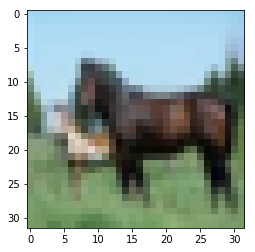

In [4]:
import matplotlib.pyplot as plt
print(X_train[12].shape)
plt.imshow(X_train[12])

In [5]:
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

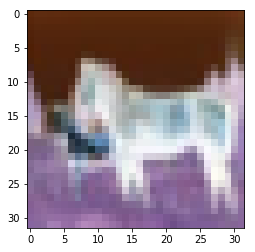

In [6]:
plt.imshow(X_train[12])

I don't understand why the pony appears in negative, but it's ok

Now: normalize X, and one-hot encode the target

In [7]:
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_test) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

Let's make our first model. Just two convolutions, one maxpool, a flatten, and a softmax layer.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
model = Sequential()

conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
# First convolution. 32 filters, 3x3 filters
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), 
                        padding='same', activation='relu', input_shape=(height, width, depth)))

model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), 
                        padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

In [11]:
num_epochs = 1

model.fit(X_train, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) 

Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 84s 2ms/step - loss: 1.3488 - acc: 0.5274 - val_loss: 1.1106 - val_acc: 0.6190


In [12]:
model.evaluate(X_test, Y_test, verbose=1)

10000/10000 [==============================] - 6s 552us/step


[1.1239460359573363, 0.6069]

Wow. 60% accuracy on just one epoch!

In [13]:
num_epochs = 10

model.fit(X_train, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) 

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 83s 2ms/step - loss: 1.0003 - acc: 0.6531 - val_loss: 0.9672 - val_acc: 0.6704
Epoch 2/10
45000/45000 [==============================] - 83s 2ms/step - loss: 0.8818 - acc: 0.6969 - val_loss: 0.9563 - val_acc: 0.6656
Epoch 3/10
45000/45000 [==============================] - 82s 2ms/step - loss: 0.8059 - acc: 0.7213 - val_loss: 0.9600 - val_acc: 0.6776
Epoch 4/10
45000/45000 [==============================] - 80s 2ms/step - loss: 0.7406 - acc: 0.7439 - val_loss: 0.9436 - val_acc: 0.6792
Epoch 5/10
45000/45000 [==============================] - 80s 2ms/step - loss: 0.6775 - acc: 0.7648 - val_loss: 0.9507 - val_acc: 0.6874
Epoch 6/10
45000/45000 [==============================] - 80s 2ms/step - loss: 0.6251 - acc: 0.7831 - val_loss: 1.0092 - val_acc: 0.6796
Epoch 7/10
45000/45000 [==============================] - 84s 2ms/step - loss: 0.5686 - acc: 0.8025 - val_loss: 1.0433 - val_acc:

In [14]:
model.evaluate(X_test, Y_test, verbose=1)

10000/10000 [==============================] - 6s 564us/step


[1.3079205474853515, 0.64639999999999997]

It got quite better, in fact.

## Adding dropout

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2

model = Sequential()
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), 
                        padding='same', activation='relu', input_shape=(height, width, depth)))

model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), 
                        padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dropout(drop_prob_1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

In [18]:
num_epochs = 10

model.fit(X_train, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) 

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 89s 2ms/step - loss: 1.4492 - acc: 0.4863 - val_loss: 1.1811 - val_acc: 0.5862
Epoch 2/10
45000/45000 [==============================] - 80s 2ms/step - loss: 1.1143 - acc: 0.6112 - val_loss: 1.0402 - val_acc: 0.6416
Epoch 3/10
45000/45000 [==============================] - 82s 2ms/step - loss: 0.9923 - acc: 0.6548 - val_loss: 0.9548 - val_acc: 0.6750
Epoch 4/10
45000/45000 [==============================] - 79s 2ms/step - loss: 0.9227 - acc: 0.6776 - val_loss: 0.9775 - val_acc: 0.6634
Epoch 5/10
45000/45000 [==============================] - 83s 2ms/step - loss: 0.8693 - acc: 0.6997 - val_loss: 0.9341 - val_acc: 0.6836
Epoch 6/10
45000/45000 [==============================] - 85s 2ms/step - loss: 0.8261 - acc: 0.7133 - val_loss: 0.9271 - val_acc: 0.6832
Epoch 7/10
45000/45000 [==============================] - 81s 2ms/step - loss: 0.7897 - acc: 0.7259 - val_loss: 0.9166 - val_acc:

In [19]:
model.evaluate(X_test, Y_test, verbose=1)

10000/10000 [==============================] - 6s 552us/step


[0.99343153419494634, 0.66090000000000004]

It improves about 1.5%